# Openpaths.cc visualization
For the last two years, I've used a [R Markdown](http://rmarkdown.rstudio.com/) [file](https://github.com/habi/jahresrueckblick/blob/master/OpenPaths.Rmd) to visualize my [OpenPaths.cc](http://openpaths.cc/)-data and give some insight on my wherebaouts in the passed year.
I've been using Python a *ton* more this year, and got to love both [Jupyter](http://jupyter.org) and [mplleaflet](https://github.com/jwass/mplleaflet) (for my [happy new year card](http://nbviewer.jupyter.org/github/habi/2017/blob/master/2017.ipynb)).
And also because I can more easily massage the data in Python, I've switched the old "analysis" to this Jupyter notebook.

To visualize the OpenPaths data, we first have to import some Python packages 

In [1]:
# Imports
import numpy  # Numerical calculations
numpy.seterr(divide='ignore', invalid='ignore')  # We use 'log' below for (sub)zero values and don't want to be warned
import matplotlib.pyplot as plt  # The de-facto standard for Python plotting
%matplotlib inline
import mplleaflet  # Easy matplotlib plots to interactive Leaflet web maps
import pandas  # Data analysis and statistics
import geopy  # Geodata handling
from geopy.geocoders import Nominatim  # Address search from OpenStreetMap
import geopandas as gpd  # Geodata handling, again

# Setup some default values
plt.rcParams['image.cmap'] = 'viridis'  # Change default colormap to a nice one (https://bids.github.io/colormap/)
plt.rcParams['figure.figsize'] = (16, 9)  # We live in a widescreen world

At first we use the `pandas` CSV reader to import the data.
The fourth column is the date colums, so we immediately parse this as a date.

In [2]:
# Load data from CSV
openpaths = pandas.read_csv('openpaths_habi.csv', parse_dates=[3])
openpaths.describe()

lat           lon           alt       version
count  28275.000000  28275.000000  28275.000000  2.827500e+04
mean      46.336489     14.821240    514.422474  1.100000e+00
std        3.143443     29.446446    362.733171  2.220485e-16
min       30.024679     -9.880663    -48.000000  1.100000e+00
25%       46.931829      7.437073    356.000000  1.100000e+00
50%       46.968079      7.900918    489.330231  1.100000e+00
75%       47.481705      8.220958    553.736145  1.100000e+00
max       53.586563    141.174377   3893.417969  1.100000e+00

Since we're only interested in this years data, we subset the so called dataframe to 2016.
If we want to show *all* the data in the file, we could set `plot_current_year' to `False`, then no subsetting happens.

In [3]:
# Use only this years data
plot_current_year = True
if plot_current_year:
    whichyear = 2016
    thisyear = openpaths[pandas.Timestamp(str(whichyear)) < openpaths['date']]
    thisyear = thisyear[thisyear['date'] < pandas.Timestamp(str(whichyear + 1))]
    thisyear.describe()
else:
    thisyear = openpaths
# Show the beginning of the dataframe
thisyear.head()

lat       lon          alt                date     device     os  \
22765  46.286259  7.798826  1208.067993 2016-01-01 07:57:52  iPhone6,2  9.2.1   
22766  46.294952  7.800951  1017.783081 2016-01-01 10:57:04  iPhone6,2  9.2.1   
22767  46.304230  7.801154   640.996643 2016-01-01 11:03:28  iPhone6,2  9.2.1   
22768  46.306042  7.809315   640.624329 2016-01-01 11:14:08  iPhone6,2  9.2.1   
22769  46.313583  7.823861   635.348633 2016-01-01 11:22:40  iPhone6,2  9.2.1   

       version  
22765      1.1  
22766      1.1  
22767      1.1  
22768      1.1  
22769      1.1

I'm still using an iPhone 5S ([`iPhone6,2`](http://www.everymac.com/ultimate-mac-lookup/?search_keywords=iPhone6%2C2)) the whole year (when the new Salt-store opened in town one could get repairs for half the price. I wanted to fix my broken display and get a new battery on my nearly three year old phone. Insted of repairing the phone, I got a new one for a *very* good price, so it's actually two different phones, but the same model).
I went through 9 different versions of iOS.
If we assume that the app tracked the positions equally for each version, then I've used iOS 9.3 the longest, with nearly 2000 data points.

In [4]:
print('Iphone models: %s' % thisyear['device'].unique()[0])
print('iOS versions: %s' % len(thisyear['os'].unique()))
for version in sorted(thisyear['os'].unique()):
    print('Version %s:\t%4s data points' % (version, len(thisyear[thisyear['os'] == version])))

Iphone models: iPhone6,2
iOS versions: 9
Version 10.0:	1149 data points
Version 10.0.2:	 706 data points
Version 10.1.1:	 378 data points
Version 10.2:	  33 data points
Version 9.2.1:	 256 data points
Version 9.3:	1979 data points
Version 9.3.1:	 214 data points
Version 9.3.2:	 535 data points
Version 9.3.5:	 256 data points


Let's see where we've been all this year.
For the overview we use the nice ['Toner' maps from Stamen](http://maps.stamen.com/toner/#5/49.810/7.822).

It seems that I've been only in Switzerland and Morocco.
Unfortunately, most of data from May is missing, so there's no location points from our vacation in [Sardinia](https://flic.kr/s/aHskBCjBe5)...

In [5]:
# Plot a subset of the data points
# We use a subset of the data to not overwhelm the map...
subset=10
plt.scatter(thisyear['lon'][::subset],
            thisyear['lat'][::subset], edgecolor='none', alpha=0.618, s=200)
mplleaflet.display(tiles='stamen_toner')

By using [the geocoding library for Python](https://github.com/geopy/geopy) and the [OpenStreetMap reverse geocoding tool](https://wiki.openstreetmap.org/wiki/Nominatim) we can assign addresses to data points.
And display these on top of the standard 'OSM' map.

Let's look at one particular location, namely the average location we had this year.
By using different keys of the `location` dictionary (`print(location.raw)`) we can get a nice text output.

In [6]:
# Address search with `geopy` and https://wiki.openstreetmap.org/wiki/Nominatim
geolocator = Nominatim()
location = geolocator.reverse('%s, %s' % (thisyear['lat'].mean(), thisyear['lon'].mean()))
#print(location.raw)
print('The average location in %s was in %s in %s' % (whichyear,
                                                      location.raw.get('address').get('suburb'),
                                                      location.raw.get('address').get('country')))
plt.scatter(thisyear['lon'].mean(), thisyear['lat'].mean(), s=500, alpha=0.618)
mplleaflet.display()

The average location in 2016 was in Chardonnière in France


Let's look at the extremes of the four cardinal directions.

In [7]:
# Cardinal directions extremes: north
point = (thisyear[thisyear['lat'] == thisyear['lat'].max()])
location = geolocator.reverse('%s, %s' % (point.iloc[0]['lat'], point.iloc[0]['lon']))
#print(location.raw)
print('The most northern location in %s was in %s in %s' % (whichyear,
                                                            location.raw.get('address').get('village'),
                                                            location.raw.get('address').get('country')))
plt.scatter(point.iloc[0]['lon'], point.iloc[0]['lat'], s=500, alpha=0.618)
mplleaflet.display()

The most northern location in 2016 was in Döttingen in Schweiz, Suisse, Svizzera, Svizra


In [8]:
# Cardinal directions extremes: east
point = (thisyear[thisyear['lon'] == thisyear['lon'].max()])
location = geolocator.reverse('%s, %s' % (point.iloc[0]['lat'], point.iloc[0]['lon']))
#print(location.raw)
print('The most eastern location in %s was in %s in %s' % (whichyear,
                                                           location.raw.get('address').get('village'),
                                                           location.raw.get('address').get('country')))
plt.scatter(point.iloc[0]['lon'], point.iloc[0]['lat'], s=500, alpha=0.618)
mplleaflet.display()

The most eastern location in 2016 was in Landquart in Schweiz, Suisse, Svizzera, Svizra


In [9]:
# Cardinal directions extremes: south
point = (thisyear[thisyear['lat'] == thisyear['lat'].min()])
location = geolocator.reverse('%s, %s' % (point.iloc[0]['lat'], point.iloc[0]['lon']))
#print(location.raw)
print('The most southern location in %s was in %s in %s' % (whichyear,
                                                            location.raw.get('address').get('village'),
                                                            location.raw.get('address').get('country')))
plt.scatter(point.iloc[0]['lon'], point.iloc[0]['lat'], s=500, alpha=0.618)
mplleaflet.display(tiles='osm')

The most southern location in 2016 was in Sidi Ouassay ⵙⵉⴷⵉ ⵡⴰⵙⴰⵢ سيدي وساي in Maroc ⵍⵎⵖⵔⵉⴱ المغرب


In [10]:
# Cardinal directions extremes: west
point = (thisyear[thisyear['lon'] == thisyear['lon'].min()])
location = geolocator.reverse('%s, %s' % (point.iloc[0]['lat'], point.iloc[0]['lon']))
#print(location.raw)
print('The most western location in %s was in %s in %s' % (whichyear,
                                                           location.raw.get('address').get('town'),
                                                           location.raw.get('address').get('country')))
plt.scatter(point.iloc[0]['lon'], point.iloc[0]['lat'], s=500, alpha=0.618)
mplleaflet.display(tiles='osm')

The most western location in 2016 was in Tamri ⵜⴰⵎⵔⵉ تامري in Maroc ⵍⵎⵖⵔⵉⴱ المغرب


It's equally easy to grab the highest and lowest point in the year.

In [11]:
# Highest point
point = thisyear.loc[thisyear['alt'] == thisyear['alt'].max()]
location = geolocator.reverse('%s, %s' % (point.iloc[0]['lat'], point.iloc[0]['lon']))
# print(location.raw)
print('The highest point in %s was on the %s in %s at %0.1f MASL' % (whichyear,
                                                                     location.raw.get('address').get('footway'),
                                                                     location.raw.get('address').get('village'),
                                                                     point['alt']))
plt.scatter(point['lon'], point['lat'], s=500, alpha=0.618)
mplleaflet.display(tiles='osm')

The highest point in 2016 was on the Klein Matterhorn in Zermatt at 3893.4 MASL


In [12]:
# Lowest point
above_sealevel = thisyear.loc[thisyear['alt'] > 0] # there's some wrong GPS data, we didn't dive with the phone :)
point = above_sealevel.loc[above_sealevel['alt'] == above_sealevel['alt'].min()]
location = geolocator.reverse('%s, %s' % (point.iloc[0]['lat'], point.iloc[0]['lon']))
location = geolocator.reverse('%s, %s' % (point.iloc[0]['lat'], point.iloc[0]['lon']))
#print(location.raw)
print('The lowest point in %s was in %s in %s at %0.1f MASL' % (whichyear,
                                                                location.raw.get('address').get('village'),
                                                                location.raw.get('address').get('country'),
                                                                point.iloc[0]['alt']))
plt.scatter(point['lon'], point['lat'], s=500, alpha=0.618)
mplleaflet.display(tiles='osm')

The lowest point in 2016 was in Sidi Ouassay ⵙⵉⴷⵉ ⵡⴰⵙⴰⵢ سيدي وساي in Maroc ⵍⵎⵖⵔⵉⴱ المغرب at 1.6 MASL


Let's "zoom" in on the data just for Switzerland.
For this we subset the [Longitude](https://en.wikipedia.org/wiki/Longitude) and [Latitude](https://en.wikipedia.org/wiki/Latitude) data on Switzerland, which is around [47°N, 8°E](http://www.wolframalpha.com/input/?i=lat+lon+switzerland).
For kicks we color the data points according to their altitude.

In [13]:
# Get the subset of swiss locations
location_in_switzerland = thisyear.loc[thisyear['lon'] > 8 - 3]
location_in_switzerland = location_in_switzerland.loc[location_in_switzerland['lon'] < 8 + 3]
location_in_switzerland = location_in_switzerland.loc[location_in_switzerland['lat'] > 47 - 1.5]
location_in_switzerland = location_in_switzerland.loc[location_in_switzerland['lat'] < 47 + 1.5]

In [14]:
# Plot all CH data points, colored by their altitude
plt.scatter(location_in_switzerland['lon'],
            location_in_switzerland['lat'],
            c=numpy.log(location_in_switzerland['alt']), edgecolor='none', alpha=0.618, s=200)
mplleaflet.display(tiles='stamen_toner')

# Bonus content!
Based on the idea found in [this blog post](http://lenguyenthedat.com/drawing-maps-python/) we get a shape file of Switzerland from [Mapzen](https://mapzen.com/data/borders/) (direct link [here](https://s3.amazonaws.com/osm-polygons.mapzen.com/switzerland_geojson.tgz)).
On top of this we do a [hexbin plot](http://matplotlib.org/examples/pylab_examples/hexbin_demo.html) of the location in Switzerland, especially for [Yves](http://habi.gna.ch/2016/01/15/where-have-i-been-in-2015/#comment-22434).
The color in this plot corresponds to the amount of data points in each bin, i.e. amount of time spent there.
It seems that I was quite a bit in Bern, Villigen and along the axis inbetween.

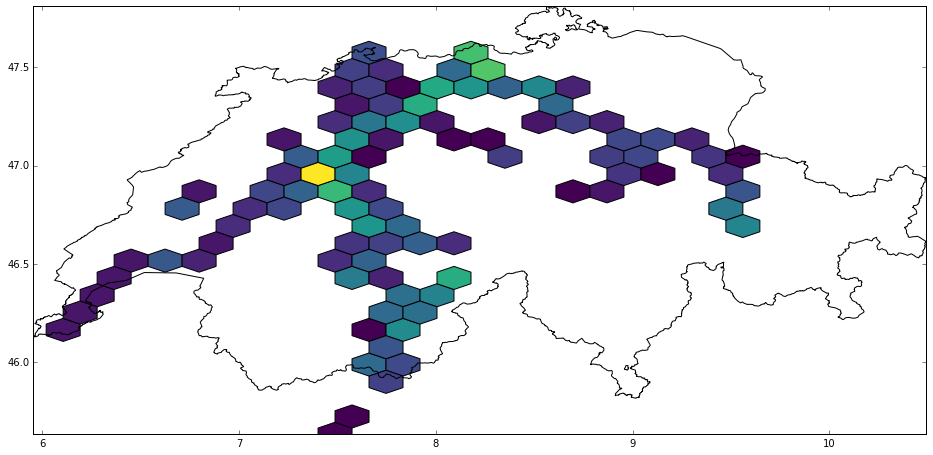

In [15]:
# Load the shape file of Switzerland and display it
switzerland = gpd.GeoDataFrame.from_file('admin_level_2.geojson')
switzerland.geometry.plot(facecolor='none')
# Overplot Switzerland with a hexagon plot of the location data.
plt.hexbin(location_in_switzerland['lon'], location_in_switzerland['lat'],
           cmap='viridis',
           gridsize=20,
           bins='log',
           mincnt=1,
           edgecolor='k')
plt.show()